# Forecast Cab Booking Demand

#### Importing Required Libraries

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np 
from datetime import datetime
import sys
import math

#package for encoding catergorical column
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold,cross_validate
from sklearn.model_selection import GridSearchCV
#machine learning algorithms
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
#metrics
from sklearn.metrics import confusion_matrix,r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import accuracy_score



# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#### Ignoring warning

In [2]:
import warnings
warnings.filterwarnings("ignore")

#### Loading Test and Train Data. Also verifying it's properties

In [3]:
train = pd.read_csv('Dataset/train.csv')
test = pd.read_csv('Dataset/test.csv')

train_lab = pd.read_csv('Dataset/train_label.csv', header=None)
train_lab.columns =['total_booking'] # Adding Column name in data

test_lab = pd.read_csv('Dataset/test_label.csv', header=None)
test_lab.columns =['total_booking']  # Adding Column name in data

#### Appending the two datasets for Train and Test

In [4]:
train = pd.concat([train, train_lab], axis=1)
test = pd.concat([test, test_lab], axis=1)

In [5]:
print("Shape of training data: ",train.shape)
print("Shape of training data: ",train_lab.shape)
print("Shape of test data:     ",test.shape)
print("Shape of test data:     ",test_lab.shape)

Shape of training data:  (8708, 10)
Shape of training data:  (8708, 1)
Shape of test data:      (2178, 10)
Shape of test data:      (2178, 1)


#### Datatype of Traning Data

In [6]:
train.dtypes

datetime          object
season            object
holiday            int64
workingday         int64
weather           object
temp             float64
atemp            float64
humidity           int64
windspeed        float64
total_booking      int64
dtype: object

#### Datatype of Test Data

In [7]:
test.dtypes

datetime          object
season            object
holiday            int64
workingday         int64
weather           object
temp             float64
atemp            float64
humidity           int64
windspeed        float64
total_booking      int64
dtype: object




#### Check for missing values in Train and Test Data

In [8]:
train.isnull().sum()

datetime         0
season           0
holiday          0
workingday       0
weather          0
temp             0
atemp            0
humidity         0
windspeed        0
total_booking    0
dtype: int64

In [9]:
test.isnull().sum()

datetime         0
season           0
holiday          0
workingday       0
weather          0
temp             0
atemp            0
humidity         0
windspeed        0
total_booking    0
dtype: int64

#### Feature Engineering on Datetime column
#### Label Encoding Season and Weather into categories

In [10]:
#Defining Categories for columns
season_type = CategoricalDtype(categories=train['season'].unique(), ordered=True)
holiday_type = CategoricalDtype(categories=train['holiday'].unique(), ordered=True)
workingday_type = CategoricalDtype(categories=train['workingday'].unique(), ordered=True)
weather_type = CategoricalDtype(categories=train['weather'].unique(), ordered=True)

In [11]:
#Function to for feature extraction

def feature_extract(df):
    df["datetime"] = pd.to_datetime(df["datetime"])
    df["month"] = df["datetime"].dt.month
    df["day"] = df["datetime"].dt.day
    df["hour"] = df["datetime"].dt.hour
    df["weekday"] = df["datetime"].dt.weekday

    # Dropping Column Date time
    df.drop(columns = ["datetime"], inplace=True)
    
    #Coerceing Columns into Category type
    df['season'] = df['season'].astype(season_type)
    df['holiday'] = df['holiday'].astype(holiday_type)
    df['workingday'] = df['workingday'].astype(workingday_type)
    df['weather'] = df['weather'].astype(weather_type)
    
    # creating instance of labelencoder
    #labelencoder = LabelEncoder()
    #df["season_cat"] = labelencoder.fit_transform(df["season"])
    #df["weather_cat"] = labelencoder.fit_transform(df["weather"])
    
    return df    

In [12]:
train = feature_extract(train)
train.head()
train.dtypes

season           category
holiday          category
workingday       category
weather          category
temp              float64
atemp             float64
humidity            int64
windspeed         float64
total_booking       int64
month               int64
day                 int64
hour                int64
weekday             int64
dtype: object

In [13]:
test = feature_extract(test)
test.head()
test.dtypes

season           category
holiday          category
workingday       category
weather          category
temp              float64
atemp             float64
humidity            int64
windspeed         float64
total_booking       int64
month               int64
day                 int64
hour                int64
weekday             int64
dtype: object

In [14]:
train.describe()

,temp,atemp,humidity,windspeed,total_booking,month,day,hour,weekday
count,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000
mean,20.243020,23.655552,61.649173,12.843891,193.007005,6.528709,10.009531,11.581190,3.015618
std,7.813494,8.501107,19.199578,8.190314,181.552211,3.440879,5.480540,6.890534,2.006246
min,0.820000,0.760000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,13.940000,16.665000,46.000000,7.001500,43.000000,4.000000,5.000000,6.000000,1.000000
50%,20.500000,24.240000,61.000000,12.998000,148.000000,7.000000,10.000000,12.000000,3.000000
75%,26.240000,31.060000,77.000000,16.997900,286.000000,10.000000,15.000000,18.000000,5.000000
max,41.000000,45.455000,100.000000,56.996900,977.000000,12.000000,19.000000,23.000000,6.000000


### Using Box Plot to find outliers

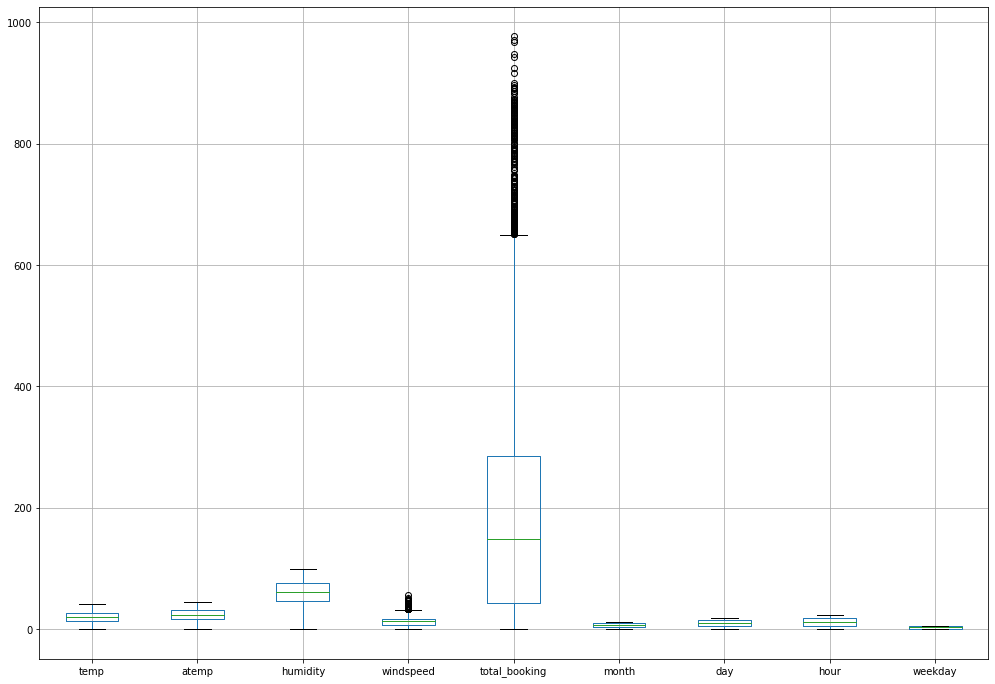

In [15]:
train.boxplot(figsize=(17,12))
plt.show()

#### Observations from Box Plot:
###### 1. Windspeed has outliers
###### 2. Total Booking has outliers


#### Removing the outliers

In [16]:
percentiles = train['windspeed'].quantile([0.01,0.97]).values #Filtering 1%(0-1), 1%(97-100) extreme outlier data
train['windspeed'] = np.clip(train['windspeed'], percentiles[0], percentiles[1])

In [17]:
percentiles = train['total_booking'].quantile([0.01,0.97]).values #Filtering 1%(0-1), 1%(97-100) extreme outlier data
train['total_booking'] = np.clip(train['total_booking'], percentiles[0], percentiles[1])

#### Verifying if outliers has been removed using Box Plot

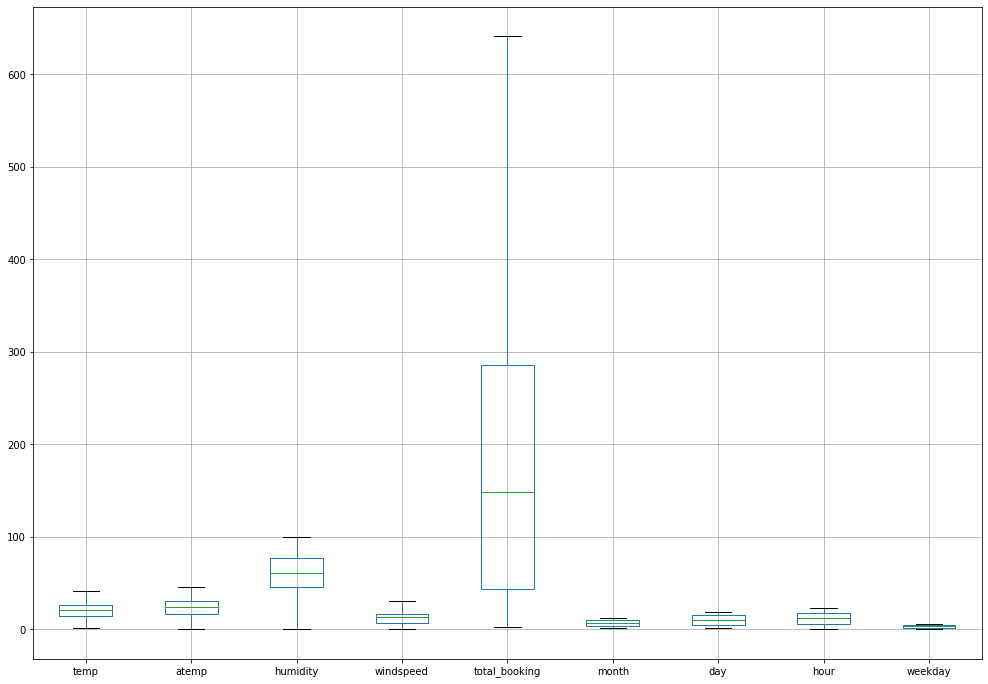

In [18]:
train.boxplot(figsize=(17,12))
plt.show()

#### Describing the data to verify it's details

In [19]:
train.describe()

,temp,atemp,humidity,windspeed,total_booking,month,day,hour,weekday
count,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000
mean,20.243020,23.655552,61.649173,12.703306,189.887804,6.528709,10.009531,11.581190,3.015618
std,7.813494,8.501107,19.199578,7.811796,172.103025,3.440879,5.480540,6.890534,2.006246
min,0.820000,0.760000,0.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000
25%,13.940000,16.665000,46.000000,7.001500,43.000000,4.000000,5.000000,6.000000,1.000000
50%,20.500000,24.240000,61.000000,12.998000,148.000000,7.000000,10.000000,12.000000,3.000000
75%,26.240000,31.060000,77.000000,16.997900,286.000000,10.000000,15.000000,18.000000,5.000000
max,41.000000,45.455000,100.000000,30.002600,641.000000,12.000000,19.000000,23.000000,6.000000


In [20]:
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,total_booking,month,day,hour,weekday
0,Summer,0,1,Clear + Few clouds,22.14,25.760,77,16.9979,504,5,2,19,2
1,Fall,0,1,Clear + Few clouds,28.70,33.335,79,19.0012,5,9,5,4,2
2,Spring,0,1,Clear + Few clouds,5.74,6.060,50,22.0028,139,1,13,9,3
3,Winter,0,1,Clear + Few clouds,13.94,16.665,29,8.9981,209,11,18,16,4
4,Fall,0,1,Clear + Few clouds,30.34,33.335,51,19.0012,184,9,13,13,1



#### Performing Correlation Analysis


In [21]:
corr_column = ['total_booking','temp','atemp','humidity','windspeed']
correlation = train[corr_column].corr()
correlation

,total_booking,temp,atemp,humidity,windspeed
total_booking,1.000000,0.402604,0.398079,-0.314163,0.101538
temp,0.402604,1.000000,0.984035,-0.066419,-0.022756
atemp,0.398079,0.984035,1.000000,-0.044206,-0.063804
humidity,-0.314163,-0.066419,-0.044206,1.000000,-0.319851
windspeed,0.101538,-0.022756,-0.063804,-0.319851,1.000000


### Inference of correlation Analysis
#### 1. Humidity is weakly negatively correlated with Total Booking ie. higher the humidity lesser the Cab booking
#### 2. Windspeed is not correlated with total booking.
#### 3. Temp and Atemp are weakly positively correlated with Total booking ie. higher the temperature higher the booking
#### 4. temp and atemp are highly correlated so atemp cam be removed as independent variable.
#### 5. Humitdy and windspeed are negatively correlated. So humidity can be removed as independent variable.

##           


## Performing Data Visualization

#### Creating a Probability Distribution plot for Total_booking

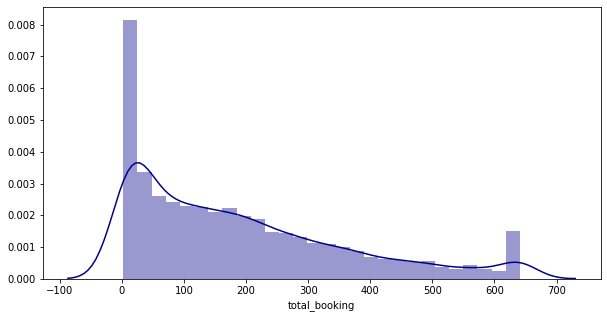

In [22]:
fig_dims = (10, 5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.distplot(train['total_booking'], kde=True, color = 'darkblue')

#### Visualizing Total Booking vs Day, Month, Weekday, Hour

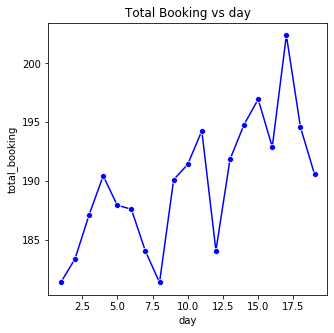

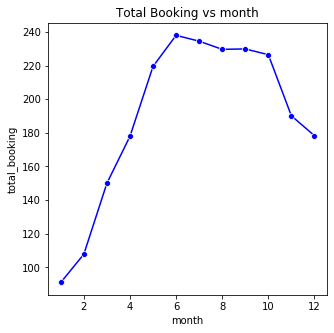

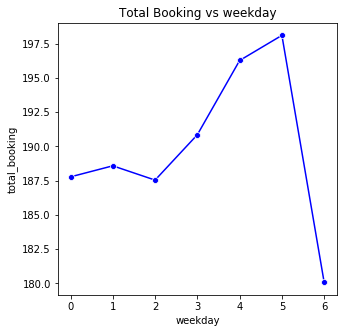

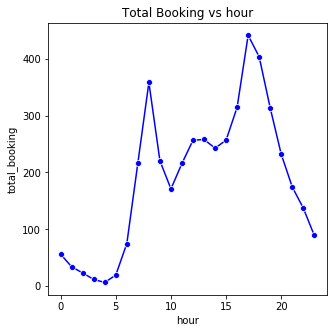

In [23]:
for col in ['day','month','weekday','hour']:
    fig_dims = (5, 5)
    fig, ax = plt.subplots(figsize=fig_dims)
    visual_column = ['total_booking',col]
    sns.lineplot(data=train[visual_column], x=col,y='total_booking',color = 'blue',ci=None,marker='o')
    plt.title("Total Booking vs "+ col)

#### Visualizing for Categorical Columns

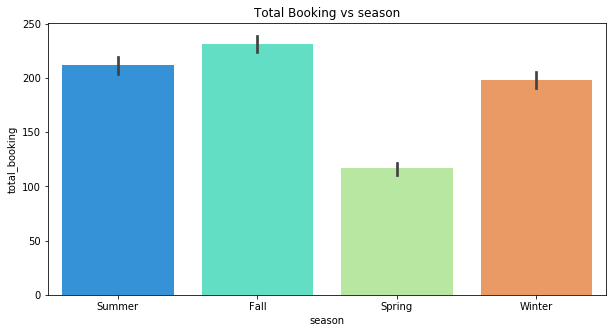

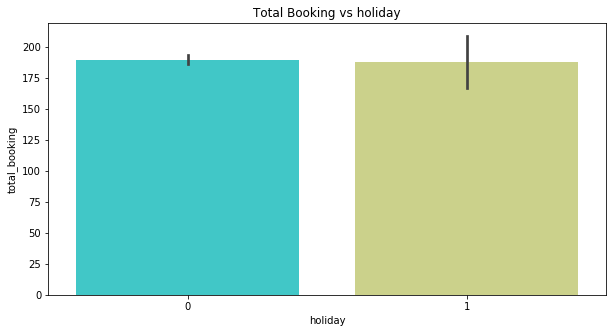

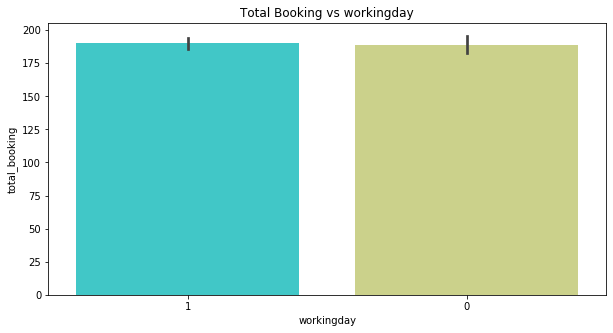

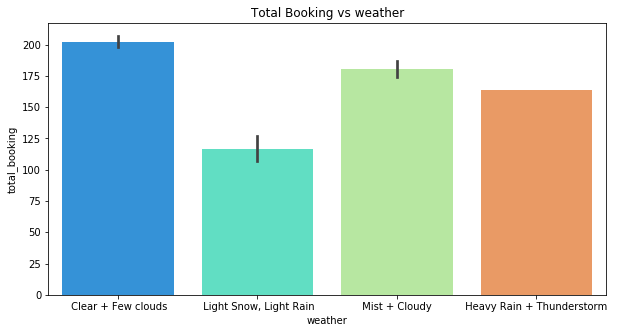

In [24]:
for col in ['season','holiday','workingday','weather']:
    fig_dims = (10, 5)
    fig, ax = plt.subplots(figsize=fig_dims)
    visual_column = ['total_booking',col]
    sns.barplot(x=col,y='total_booking',data=train[visual_column], palette='rainbow')
    plt.title("Total Booking vs "+ col)

#### Create histogram for contineous variables

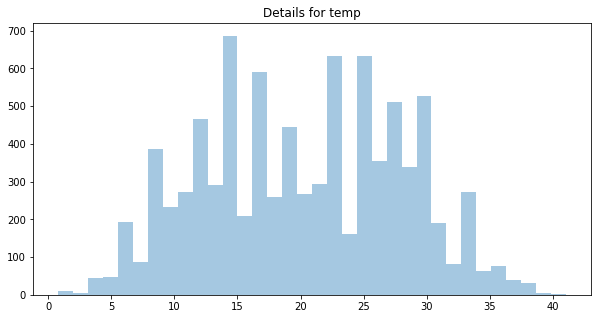

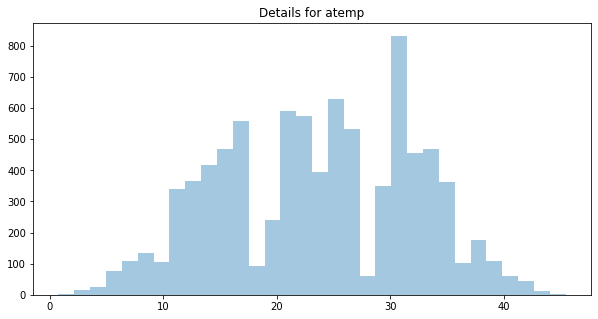

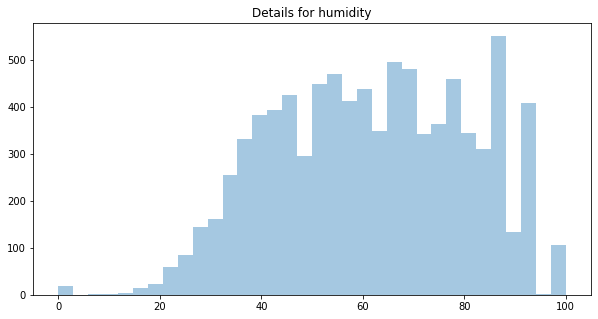

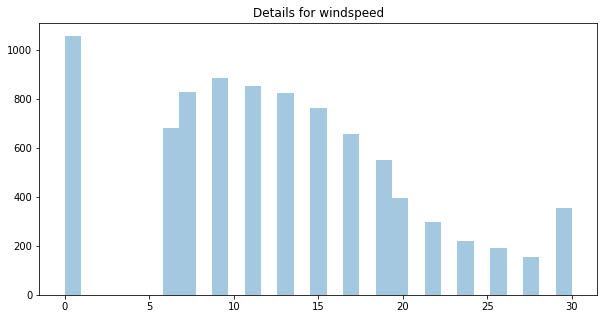

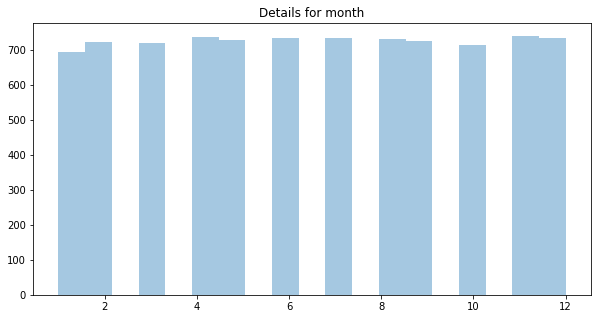

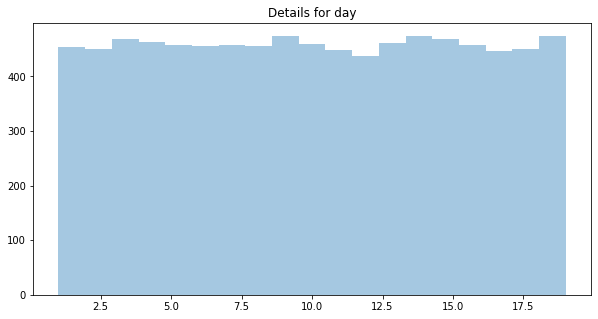

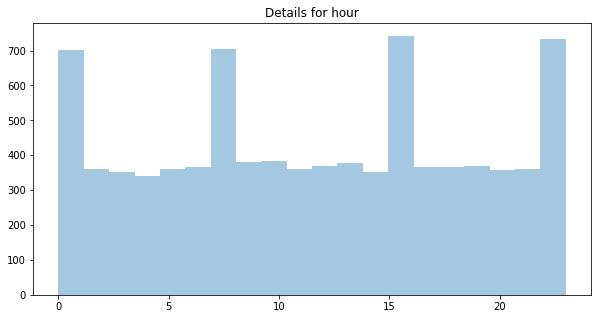

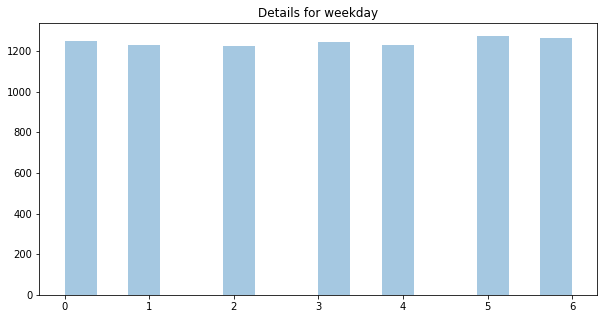

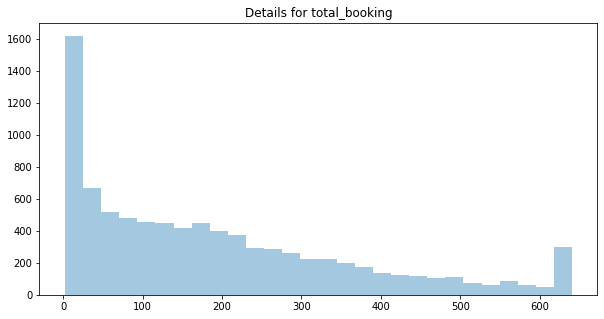

In [25]:

for col in ['temp','atemp','humidity','windspeed','month','day','hour','weekday','total_booking']:
    fig_dims = (10, 5)
    fig, ax = plt.subplots(figsize=fig_dims)
    visual_column = [col]
    sns.distplot(train[visual_column], kde=False)
    plt.title("Details for "+ col)

In [26]:
# Removing correlated columns
del_col = ['atemp','humidity'] 
def del_correlated_variable(df): 
    for col in del_col:
        df.drop(col, axis=1, inplace=True)
    return df

del_correlated_variable(train)
del_correlated_variable(test)

,season,holiday,workingday,weather,temp,windspeed,total_booking,month,day,hour,weekday
0,Summer,0,1,Clear + Few clouds,21.32,35.0008,256,5,10,11,3
1,Summer,0,0,Clear + Few clouds,23.78,7.0015,87,6,9,7,5
2,Spring,0,0,"Light Snow, Light Rain",11.48,27.9993,11,3,6,20,6
3,Winter,0,1,Mist + Cloudy,25.42,0.0000,84,10,13,11,3
4,Summer,0,0,Clear + Few clouds,25.42,23.9994,668,6,2,12,5
...,...,...,...,...,...,...,...,...,...,...,...
2173,Spring,0,1,Clear + Few clouds,18.86,26.0027,3,3,8,3,3
2174,Spring,0,1,Mist + Cloudy,13.94,7.0015,144,1,12,12,3
2175,Spring,0,1,Clear + Few clouds,18.86,19.9995,159,3,7,22,2
2176,Summer,0,1,Clear + Few clouds,17.22,8.9981,29,5,12,5,3


### Converting Caterogical data into OneHot Encoder

In [27]:
# Defining function
def cat_onehot(df):
    for col in ['season','holiday','workingday','weather']:
        x_dum = pd.get_dummies(df[col], prefix = col)
        df = pd.concat([df, x_dum], axis=1)
        df.drop(col, axis=1, inplace=True)
    
    return df

In [28]:
train = cat_onehot(train)
#train.drop('holiday_1', axis=1, inplace=True)
#train.drop('workingday_1', axis=1, inplace=True)
train.head()

,temp,windspeed,total_booking,month,day,hour,weekday,season_Summer,season_Fall,season_Spring,season_Winter,holiday_0,holiday_1,workingday_1,workingday_0,weather_ Clear + Few clouds,"weather_ Light Snow, Light Rain",weather_ Mist + Cloudy,weather_ Heavy Rain + Thunderstorm
0,22.14,16.9979,504,5,2,19,2,1,0,0,0,1,0,1,0,1,0,0,0
1,28.70,19.0012,5,9,5,4,2,0,1,0,0,1,0,1,0,1,0,0,0
2,5.74,22.0028,139,1,13,9,3,0,0,1,0,1,0,1,0,1,0,0,0
3,13.94,8.9981,209,11,18,16,4,0,0,0,1,1,0,1,0,1,0,0,0
4,30.34,19.0012,184,9,13,13,1,0,1,0,0,1,0,1,0,1,0,0,0


In [29]:
test = cat_onehot(test)
#test.drop('holiday_1', axis=1, inplace=True)
#test.drop('workingday_1', axis=1, inplace=True)
test.head()

,temp,windspeed,total_booking,month,day,hour,weekday,season_Summer,season_Fall,season_Spring,season_Winter,holiday_0,holiday_1,workingday_1,workingday_0,weather_ Clear + Few clouds,"weather_ Light Snow, Light Rain",weather_ Mist + Cloudy,weather_ Heavy Rain + Thunderstorm
0,21.32,35.0008,256,5,10,11,3,1,0,0,0,1,0,1,0,1,0,0,0
1,23.78,7.0015,87,6,9,7,5,1,0,0,0,1,0,0,1,1,0,0,0
2,11.48,27.9993,11,3,6,20,6,0,0,1,0,1,0,0,1,0,1,0,0
3,25.42,0.0000,84,10,13,11,3,0,0,0,1,1,0,1,0,0,0,1,0
4,25.42,23.9994,668,6,2,12,5,1,0,0,0,1,0,0,1,1,0,0,0


## Finding the best model for fit

In [30]:
# Defining paramter variables
val_random_state = 40
val_estimators = 100
val_max_depth = 4
val_n_neighbors = 4

#Creating models
models=[]

models.append(('adaboost',AdaBoostRegressor(random_state=val_random_state, n_estimators=val_estimators)))
models.append(('randomforest',RandomForestRegressor(max_depth=val_max_depth, random_state=val_random_state)))
models.append(('svr',SVR()))
models.append(('bagging',BaggingRegressor(base_estimator=SVR(),n_estimators=val_estimators, random_state=val_random_state)))
models.append(('kneighbor',KNeighborsRegressor(n_neighbors=val_n_neighbors)))


In [31]:
#Creating list of independent variable and target variable
col_target = 'total_booking'
col_ind = train.columns.to_list()
col_ind.remove(col_target)

In [32]:
#For Training Data
X_train = train[col_ind]
Y_train = train[col_target]

In [33]:
#For test data
X_test = test[col_ind]
Y_test = test[col_target]

In [34]:
#Function to log the data
def data_log(log):
    print(datetime.now().strftime("%Y-%m-%d %H:%M:%S") + ' || ' + str(log))

In [35]:
#Applying Different models and calulating RMSE

model_details=[]
for name,model in models:
    data_log('Fitting the model -----> ' + name)
    model.fit(X_train,Y_train)
    
    data_log('Predicting for model')
    Y_predict_test = model.predict(X_test)
    Y_predict_train = model.predict(X_train)
    
    data_log('Calculating RMSC Value')
    mse_test = mean_squared_error(Y_test, Y_predict_test)
    rmse_test = round(math.sqrt(mse_test),2)
    
    mse_train = mean_squared_error(Y_train, Y_predict_train)
    rmse_train = round(math.sqrt(mse_train),2)
    
    model_details.append((name,rmse_test,rmse_train))
    data_log('Root Mean Sqaure error of Test = ' +  str(rmse_test))
    data_log('Root Mean Sqaure error of Train = ' + str(rmse_train))
    

2021-06-28 18:03:17 || Fitting the model -----> adaboost
2021-06-28 18:03:17 || Predicting for model
2021-06-28 18:03:17 || Calculating RMSC Value
2021-06-28 18:03:17 || Root Mean Sqaure error of Test = 119.77
2021-06-28 18:03:17 || Root Mean Sqaure error of Train = 112.18
2021-06-28 18:03:17 || Fitting the model -----> randomforest
2021-06-28 18:03:17 || Predicting for model
2021-06-28 18:03:17 || Calculating RMSC Value
2021-06-28 18:03:17 || Root Mean Sqaure error of Test = 118.51
2021-06-28 18:03:17 || Root Mean Sqaure error of Train = 109.91
2021-06-28 18:03:17 || Fitting the model -----> svr
2021-06-28 18:03:20 || Predicting for model
2021-06-28 18:03:22 || Calculating RMSC Value
2021-06-28 18:03:22 || Root Mean Sqaure error of Test = 150.89
2021-06-28 18:03:22 || Root Mean Sqaure error of Train = 143.19
2021-06-28 18:03:22 || Fitting the model -----> bagging
2021-06-28 18:05:13 || Predicting for model
2021-06-28 18:07:28 || Calculating RMSC Value
2021-06-28 18:07:28 || Root Mean 

In [36]:
model_details

[('adaboost', 119.77, 112.18, 7.589999999999989),
 ('randomforest', 118.51, 109.91, 8.600000000000009),
 ('svr', 150.89, 143.19, 7.699999999999989),
 ('bagging', 150.96, 143.26, 7.700000000000017),
 ('kneighbor', 105.83, 73.93, 31.89999999999999)]

In [37]:
model_details = pd.DataFrame(model_details)

In [58]:
model_details.rename(columns = {0:'Model',1:'RMSE_TEST',2:'RMSE_TRAIN'},inplace=True)

In [59]:
model_details

,Model,RMSE_TEST,RMSE_TRAIN,Overfitting_by
0,adaboost,119.77,112.18,7.59
1,randomforest,118.51,109.91,8.60
2,svr,150.89,143.19,7.70
3,bagging,150.96,143.26,7.70
4,kneighbor,105.83,73.93,31.90


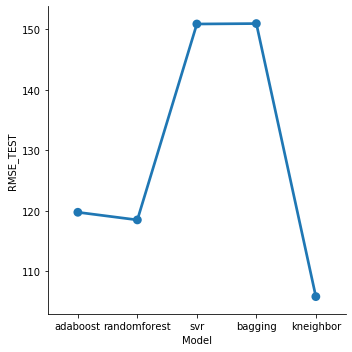

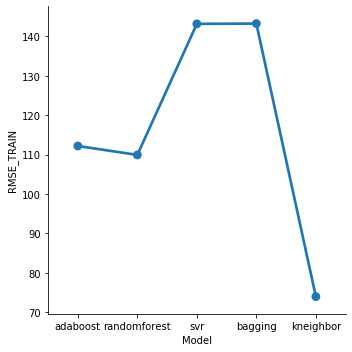

In [40]:
sns.factorplot(x ='Model', y ='RMSE_TEST', data = model_details)
sns.factorplot(x ='Model', y ='RMSE_TRAIN', data = model_details)
plt.show()

### Inference from RMSE value and Factor Plot:
#### <b>Random Forest <b> is the best model having least Root Mean Square Error

### Performaing Hyper parameter tuning using Grid Search on Random Forest

In [41]:
para_grids = {
            "n_estimators" : [10,50,100,150,200],
            "max_features" : ["auto", "log2", "sqrt"],
            "bootstrap"    : [True, False]
        }
grid = GridSearchCV(estimator=RandomForestRegressor(max_depth=val_max_depth, 
                                                    random_state=val_random_state)
                    ,param_grid=para_grids,cv=5,scoring='neg_mean_squared_error',
                   )
grid.fit(X_train,Y_train)

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_depth=4, random_state=40),
             param_grid={'bootstrap': [True, False],
                         'max_features': ['auto', 'log2', 'sqrt'],
                         'n_estimators': [10, 50, 100, 150, 200]},
             scoring='neg_mean_squared_error')

In [42]:
pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.196390,0.001788,0.006238,0.000262,True,auto,50,"{'bootstrap': True, 'max_features': 'auto', 'n...",-12857.638582,-12288.881203,-12053.663979,-11811.890794,-11661.944626,-12134.803837,419.686132,1
0,0.050635,0.011691,0.003201,0.000434,True,auto,10,"{'bootstrap': True, 'max_features': 'auto', 'n...",-12898.659930,-12315.934683,-12048.604479,-11793.680430,-11619.620390,-12135.299982,448.440135,2
3,0.587523,0.004886,0.015947,0.000274,True,auto,150,"{'bootstrap': True, 'max_features': 'auto', 'n...",-12861.484575,-12303.369851,-12025.419033,-11816.470050,-11685.672766,-12138.483255,417.476193,3
4,0.787088,0.008124,0.020497,0.000730,True,auto,200,"{'bootstrap': True, 'max_features': 'auto', 'n...",-12872.084106,-12303.516474,-12017.736693,-11822.013151,-11693.288035,-12141.727692,419.114634,4
2,0.398502,0.015444,0.011305,0.000255,True,auto,100,"{'bootstrap': True, 'max_features': 'auto', 'n...",-12863.365546,-12295.196489,-12029.882993,-11829.128965,-11709.654240,-12145.445647,410.160802,5
15,0.055975,0.001055,0.002885,0.000116,False,auto,10,"{'bootstrap': False, 'max_features': 'auto', '...",-13291.463973,-12730.033563,-12563.156641,-12262.362004,-12154.126027,-12600.228442,402.291273,6
19,1.051405,0.018596,0.020022,0.000471,False,auto,200,"{'bootstrap': False, 'max_features': 'auto', '...",-13291.463973,-12730.033563,-12563.156641,-12262.362004,-12154.126027,-12600.228442,402.291273,7
18,0.785550,0.009434,0.015150,0.000083,False,auto,150,"{'bootstrap': False, 'max_features': 'auto', '...",-13291.463973,-12730.033563,-12563.156641,-12262.362004,-12154.126027,-12600.228442,402.291273,7
17,0.523593,0.005145,0.010967,0.000570,False,auto,100,"{'bootstrap': False, 'max_features': 'auto', '...",-13291.463973,-12730.033563,-12563.156641,-12262.362004,-12154.126027,-12600.228442,402.291273,7
16,0.264440,0.003310,0.006494,0.000277,False,auto,50,"{'bootstrap': False, 'max_features': 'auto', '...",-13291.463973,-12730.033563,-12563.156641,-12262.362004,-12154.126027,-12600.228442,402.291273,7


#### Getting the best parameter

In [43]:
grid_param = grid.best_params_
print(grid_param)

{'bootstrap': True, 'max_features': 'auto', 'n_estimators': 50}


#### Building Model with best parameters

In [44]:
rf = RandomForestRegressor(max_depth=val_max_depth, random_state=val_random_state, 
                           bootstrap=grid_param['bootstrap'],
                           max_features=grid_param['max_features'],
                           n_estimators=grid_param['n_estimators']
                          )

#### Fitting the model and predicting with test data

In [45]:
rf.fit(X_train,Y_train)
Y_predict_rf = rf.predict(X_test)

##### Calculating Mean Squared Log Error 

In [46]:
print(f'Mean Squared Log Error =',round(mean_squared_log_error(Y_test, Y_predict_rf),3))

Mean Squared Log Error = 0.539
